# GARCH Model Evaluation for Financial Time Series

This notebook evaluates the performance of the GARCH(1,1) model on daily log returns from the S&P 500 index. It serves as a classical volatility modeling baseline for comparison with modern generative models (e.g., DDPM, TimeGrad) in this thesis.

The notebook includes:
- Data preprocessing and return calculation
- GARCH(1,1) model fitting and diagnostics
- Rolling 1-step-ahead Value-at-Risk (VaR) backtesting
- Kupiec and Christoffersen statistical tests
- Export of results for reproducibility and inclusion in the thesis report


In [52]:
pip install yfinance matplotlib pandas numpy statsmodels


Note: you may need to restart the kernel to use updated packages.


Data Ingestion: Loads S&P 500 historical closing prices from a local CSV file. Ensures the data is parsed as datetime and numerically valid.


In [66]:
import yfinance as yf
import pandas as pd

# Download daily data for S&P 500 (symbol ^GSPC)

data = pd.read_csv("sp500_data.csv", index_col=0, parse_dates=True)
data.index = pd.to_datetime(data.index)  
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Keep only 'Close' price
data = data[['Close']]
print(data.head())



                  Close
Date                   
2010-01-04  1132.989990
2010-01-05  1136.520020
2010-01-06  1137.140015
2010-01-07  1141.689941
2010-01-08  1144.979980


Log Return Calculation: Computes daily log returns from closing prices. Drops NaNs from the first row due to differencing.


In [67]:
import numpy as np

# Compute log returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Drop the first NaN value
data = data.dropna()

print(data.head())


                  Close  Log_Returns
Date                                
2010-01-05  1136.520020     0.003111
2010-01-06  1137.140015     0.000545
2010-01-07  1141.689941     0.003993
2010-01-08  1144.979980     0.002878
2010-01-11  1146.979980     0.001745


Train/Test Split: Splits the returns into 80% training and 20% testing data, preserving time order for backtesting integrity.


In [68]:
from sklearn.model_selection import train_test_split

# Use only the returns
returns = data['Log_Returns'].dropna()

# Split 80/20
train_returns, test_returns = train_test_split(returns, test_size=0.2, shuffle=False)

print(f"Train size: {len(train_returns)}")
print(f"Test size: {len(test_returns)}")


Train size: 3017
Test size: 755


Market Overview Plot:  
Plots the historical closing prices of the S&P 500 index to provide visual context for the dataset. This helps illustrate long-term market trends, volatility periods, and structural breaks, which justify the use of volatility modeling techniques such as GARCH.


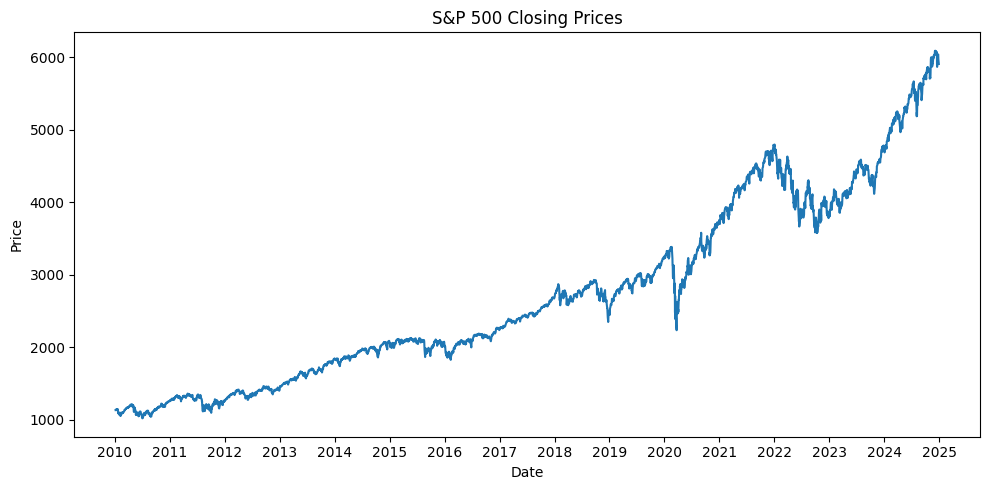

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  



plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Close'])

# Title and labels
plt.title('S&P 500 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Format x-axis ticks to show one tick per year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [70]:
print(data.index)
print(data.index.dtype)


DatetimeIndex(['2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
               '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15', '2010-01-19',
               ...
               '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19',
               '2024-12-20', '2024-12-23', '2024-12-24', '2024-12-26',
               '2024-12-27', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=3772, freq=None)
datetime64[ns]


Log Returns Plot:  
Displays the daily log returns of the S&P 500 index. This view highlights return fluctuations and volatility clustering—key stylized facts in financial time series that motivate the use of models like GARCH.


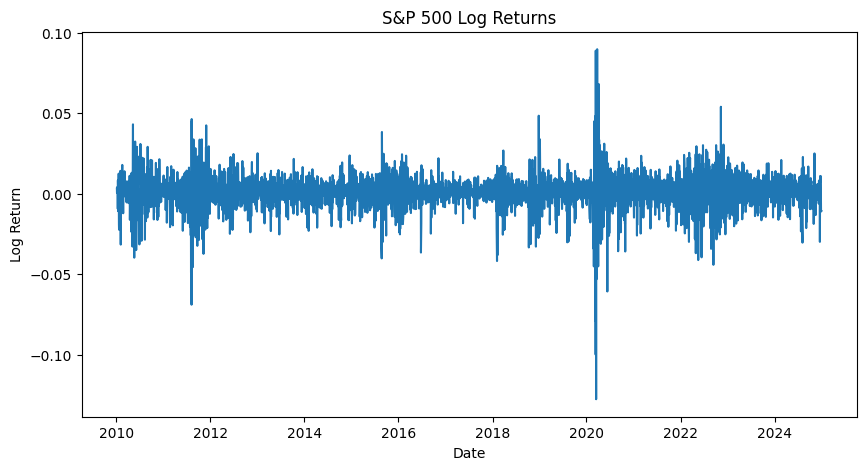

In [71]:
plt.figure(figsize=(10,5))
plt.plot(data['Log_Returns'])
plt.title('S&P 500 Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()


Return Distribution Histogram:  
Plots the distribution of daily log returns. This helps assess properties such as skewness, kurtosis, and fat tails, which often deviate from normality in financial data and support the use of heavy-tailed models.


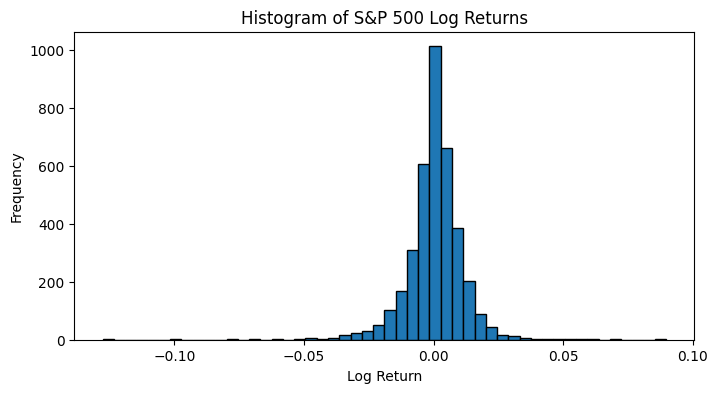

In [72]:
plt.figure(figsize=(8,4))
plt.hist(data['Log_Returns'], bins=50, edgecolor='k')
plt.title('Histogram of S&P 500 Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.show()


ACF of Squared Log Returns:  
Plots the autocorrelation of squared log returns to reveal volatility clustering—a key feature of financial time series. Persistent autocorrelation in squared returns indicates time-varying volatility, which justifies the use of GARCH-type models.


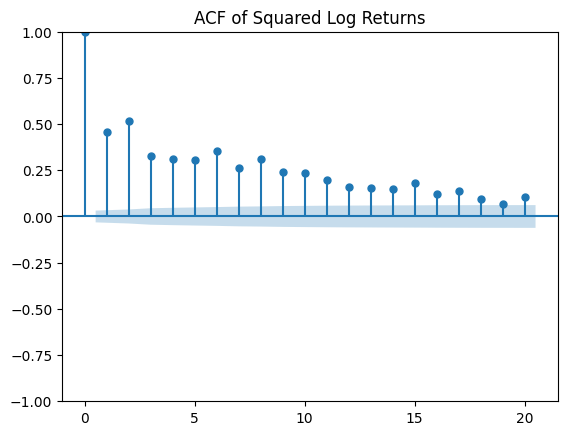

In [73]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of squared log returns
squared_returns = data['Log_Returns'] ** 2

plot_acf(squared_returns, lags=20)
plt.title('ACF of Squared Log Returns')
plt.show()


GARCH Library Installation:  
Installs the `arch` Python package, which provides tools for fitting ARCH/GARCH family models. This is required to build and evaluate the GARCH(1,1) model in later steps.


In [74]:
pip install arch


Note: you may need to restart the kernel to use updated packages.


In [75]:
from arch import arch_model
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


Rolling 1% VaR Forecast and Backtest:  
This cell performs a statistically rigorous **rolling 1-step-ahead forecast** using the GARCH(1,1) model to estimate the 1% Value-at-Risk (VaR) on the test set. At each time step:
- The model is refitted using all available past data (expanding window).
- A 1-day-ahead forecast is made for both the conditional mean and variance.
- The 1% VaR is computed using the z-score of the normal distribution.

It then compares actual returns against the VaR threshold to identify violations and computes the **violation rate**. Finally, it plots:
- Actual returns
- The 1% VaR line
- Red-shaded regions where violations occurred

This approach aligns with best practices for financial risk evaluation and supports robust model validation.


Rolling 1-step-ahead GARCH forecasts (this may take a minute)...

1% VaR Violation Rate: 2.12%
Total Violations: 16 out of 755 observations


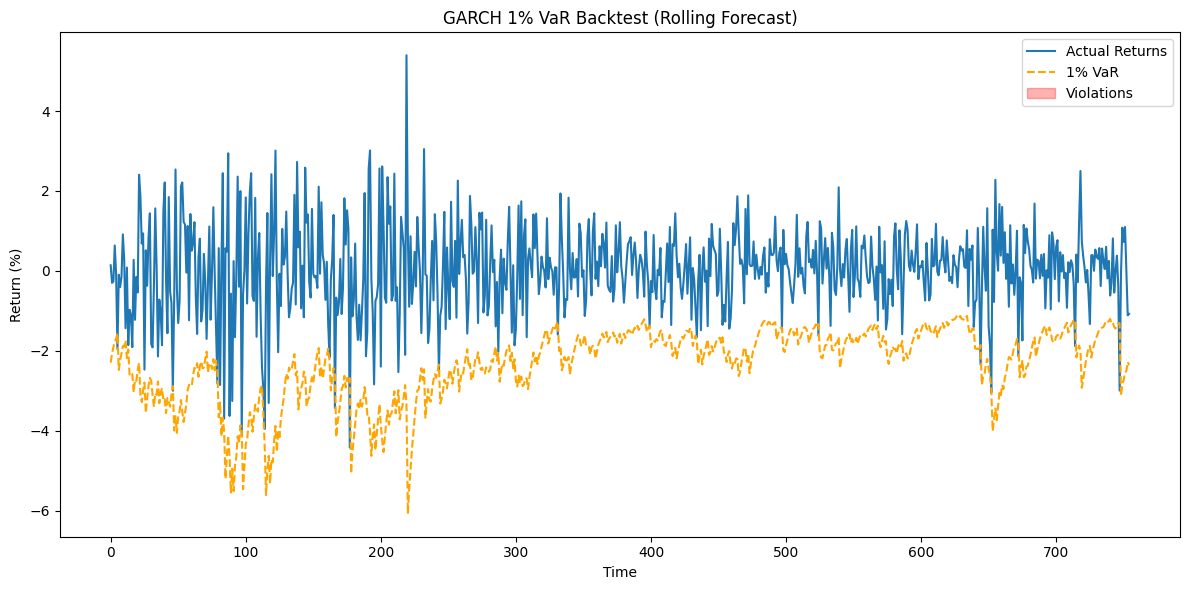

In [76]:
from arch import arch_model
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare log returns and split
returns = data['Log_Returns'].dropna()
split_idx = int(len(returns) * 0.8)
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]

# Step 2: Rolling 1-step-ahead forecasts for test set
z_score = norm.ppf(0.01)  # for 1% VaR
actual_returns = test_returns * 100  # convert to %
var1 = []
predicted_mean = []

print("Rolling 1-step-ahead GARCH forecasts (this may take a minute)...")

for i in range(len(test_returns)):
    rolling_train = pd.concat([train_returns, test_returns.iloc[:i]])
    model = arch_model(rolling_train * 100, vol='GARCH', p=1, q=1, mean='Constant')
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=1)

    mu = forecast.mean.iloc[-1, 0]
    sigma = np.sqrt(forecast.variance.iloc[-1, 0])
    predicted_mean.append(mu)
    var1.append(mu + z_score * sigma)

# Step 3: Convert to arrays
actual = actual_returns.values
var1 = np.array(var1)
violations = actual < var1
violation_rate = violations.mean()

# Step 4: Print summary
print(f"\n1% VaR Violation Rate: {violation_rate * 100:.2f}%")
print(f"Total Violations: {violations.sum()} out of {len(violations)} observations")

# Step 5: Plot results
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Returns')
plt.plot(var1, label='1% VaR', linestyle='--', color='orange')
plt.fill_between(np.arange(len(var1)), var1, actual,
                 where=violations, color='red', alpha=0.3, label='Violations')
plt.title("GARCH 1% VaR Backtest (Rolling Forecast)")
plt.xlabel("Time")
plt.ylabel("Return (%)")
plt.legend()
plt.tight_layout()
plt.savefig("garch_var_backtest.pdf")
plt.show()


Kupiec and Christoffersen Backtest Statistics:  
Applies formal statistical tests to assess the quality of the GARCH VaR predictions:

- **Kupiec Test (Unconditional Coverage):**  
  Tests whether the observed number of VaR violations matches the expected number under a 1% risk level. It uses a binomial test.

- **Christoffersen Test (Violation Independence):**  
  Tests whether violations are independently distributed over time (i.e., not clustered), using a likelihood ratio test on transition probabilities.

These tests provide a statistically grounded way to validate that the model produces reliable risk forecasts beyond simple visual inspection.


In [78]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.proportion import binom_test


# Kupiec Test: Unconditional Coverage
N = len(violations)
x = violations.sum()
p = 0.01  # for 1% VaR

kupiec_pval = binom_test(x, N, p, alternative='two-sided')

print(f"Kupiec Test (Unconditional Coverage):")
print(f"Observed Violations: {x}")
print(f"Expected Violations: {int(N * p)}")
print(f"P-value: {kupiec_pval:.4f}")

# Christoffersen Test: Independence of Violations
# Create lagged indicator sequence
violation_series = violations.astype(int)
transitions = list(zip(violation_series[:-1], violation_series[1:]))

# Count transitions
n00 = transitions.count((0, 0))
n01 = transitions.count((0, 1))
n10 = transitions.count((1, 0))
n11 = transitions.count((1, 1))

pi_01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
pi_11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
pi = (n01 + n11) / (n00 + n01 + n10 + n11)

# Log-likelihood ratio test
import numpy as np

def safe_log(x):
    return np.log(x) if x > 0 else 0

LL_indep = (n00 * safe_log(1 - pi) +
            n01 * safe_log(pi) +
            n10 * safe_log(1 - pi) +
            n11 * safe_log(pi))

LL_dep = (n00 * safe_log(1 - pi_01) +
          n01 * safe_log(pi_01) +
          n10 * safe_log(1 - pi_11) +
          n11 * safe_log(pi_11))

LR_ind = -2 * (LL_indep - LL_dep)
from scipy.stats import chi2
christoffersen_pval = chi2.sf(LR_ind, df=1)

print(f"\nChristoffersen Test (Violation Independence):")
print(f"P-value: {christoffersen_pval:.4f}")


Kupiec Test (Unconditional Coverage):
Observed Violations: 16
Expected Violations: 7
P-value: 0.0052

Christoffersen Test (Violation Independence):
P-value: 0.4049


LaTeX Export of Test Results:  
Creates a summary table of the Kupiec and Christoffersen test results, including p-values and interpretations. The table is then exported to a `.tex` file for easy inclusion in the thesis report, supporting reproducibility and proper documentation of statistical validation.


In [79]:
# Create summary table for export
evaluation_results = {
    "Test": ["Kupiec (Unconditional)", "Christoffersen (Independence)"],
    "P-Value": [f"{kupiec_pval:.4f}", f"{christoffersen_pval:.4f}"],
    "Interpretation": [
        "Tests if violation rate matches expected (1%)",
        "Tests if violations are independent over time"
    ]
}

eval_df = pd.DataFrame(evaluation_results)
print(eval_df)

# Export to .tex
eval_df.to_latex("garch_var_tests.tex", index=False, column_format="lll")


                            Test P-Value  \
0         Kupiec (Unconditional)  0.0052   
1  Christoffersen (Independence)  0.4049   

                                  Interpretation  
0  Tests if violation rate matches expected (1%)  
1  Tests if violations are independent over time  


Summary Metrics Export:  
Creates a concise summary table with the total number of test samples, number of VaR violations, and the corresponding violation rate (in %). This table is exported to a `.tex` file for direct inclusion in the thesis, ensuring clear documentation of the model's risk performance.


In [80]:
import pandas as pd

summary = {
    "Test Size": [len(actual)],
    "1% VaR Violations": [violations.sum()],
    "Violation Rate (%)": [violation_rate * 100]
}

metrics_df = pd.DataFrame(summary)
print(metrics_df)

# Export to LaTeX
metrics_df.to_latex("garch_var_metrics.tex", index=False)


   Test Size  1% VaR Violations  Violation Rate (%)
0        755                 16            2.119205


GARCH(1,1) Model Fit on Training Data:  
Fits a GARCH(1,1) model with a normal distribution to the training set (in percentage scale) using the `arch` library. This provides a baseline volatility model and prints key parameters and diagnostic statistics. Although not used in the rolling VaR backtest, it supports model understanding and comparison.


In [81]:
from arch import arch_model
from sklearn.model_selection import train_test_split

# Step 1: Split the log returns into train/test (80/20)
returns = data['Log_Returns'].dropna()
train_returns, test_returns = train_test_split(returns, test_size=0.2, shuffle=False)

# Step 2: Fit GARCH(1,1) on training data (scaled to %)
model = arch_model(train_returns * 100, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
res = model.fit(disp='off')

# Step 3: Print summary
print(res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3761.62
Distribution:                  Normal   AIC:                           7531.25
Method:            Maximum Likelihood   BIC:                           7555.30
                                        No. Observations:                 3017
Date:                Sun, Aug 03 2025   Df Residuals:                     3016
Time:                        16:21:16   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0816  1.324e-02      6.160  7.292e-10 [5.562e-0

Conditional Volatility (Stylized Fact):  
Plots the time-varying conditional volatility estimated by the GARCH(1,1) model on the training set. This visualises the phenomenon of **volatility clustering** — a well-known stylized fact in financial time series. Useful for supporting model choice and theory in the thesis.


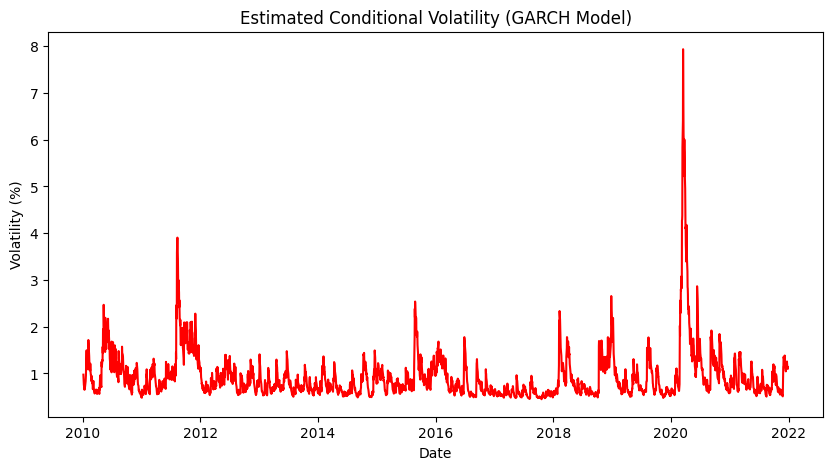

In [82]:
# Include in your thesis report as a stylized fact visual

# Get conditional volatility estimates
cond_vol = res.conditional_volatility

plt.figure(figsize=(10,5))
plt.plot(cond_vol, color='red')
plt.title('Estimated Conditional Volatility (GARCH Model)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.show()


Standardized Residuals (Model Diagnostics):  
Plots the standardized residuals from the GARCH(1,1) model on the training set. This helps assess whether residuals are uncorrelated and approximately homoscedastic — key assumptions of a well-specified GARCH model. The plot is saved as a `.pdf` for inclusion in the thesis appendix.



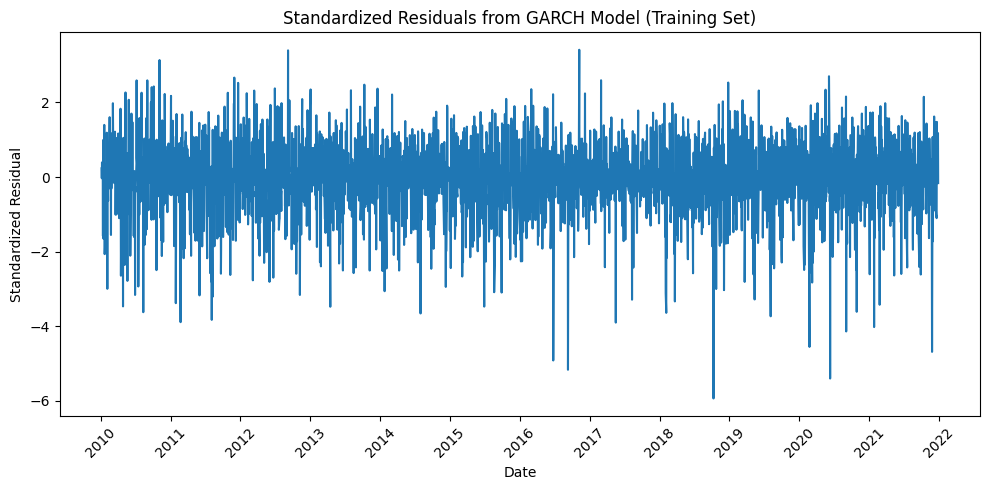

In [85]:
# # relevant for validating model assumptions
# plt.figure(figsize=(10,5))
# plt.plot(std_resid)
# plt.title('Standardized Residuals from GARCH Model (Training Set)')
# plt.xlabel('Time')
# plt.ylabel('Standardized Residual')
# plt.tight_layout()
# plt.savefig("garch_std_residuals.pdf")
# plt.show()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
plt.plot(std_resid.index, std_resid)

# Title and labels
plt.title('Standardized Residuals from GARCH Model (Training Set)')
plt.xlabel('Date')
plt.ylabel('Standardized Residual')

# Format x-axis to show 1 tick per year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Improve readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("garch_std_residuals.pdf")
plt.show()




Histogram of Standardized Residuals with Normal Overlay:  
Displays the distribution of standardized residuals from the GARCH(1,1) model and overlays a standard normal curve for comparison. This visualises **deviations from normality**, such as fat tails or skewness, which are common in financial returns. The plot is exported as a `.pdf` for inclusion in the thesis.


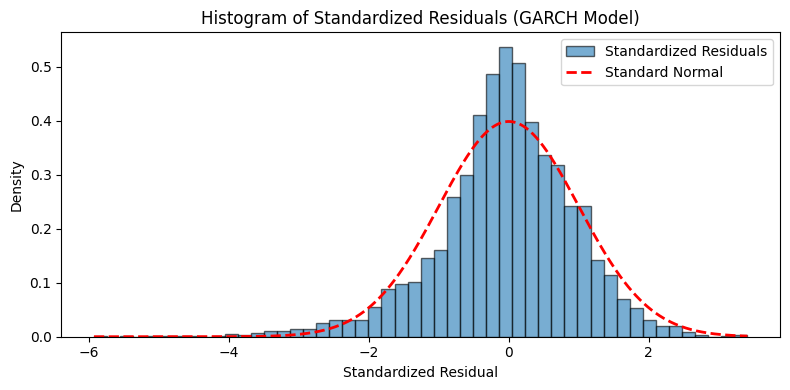

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Get standardized residuals
std_resid = res.std_resid.dropna()

# Plot histogram
plt.figure(figsize=(8, 4))
n, bins, _ = plt.hist(std_resid, bins=50, density=True, edgecolor='k', alpha=0.6, label='Standardized Residuals')

# Overlay standard normal distribution
x = np.linspace(bins[0], bins[-1], 500)
plt.plot(x, norm.pdf(x), 'r--', linewidth=2, label='Standard Normal')

# Plot formatting
plt.title('Histogram of Standardized Residuals (GARCH Model)')
plt.xlabel('Standardized Residual')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig("garch_residual_histogram.pdf")
plt.show()



Final Summary Metrics Table:  
Creates a table summarising the number of training and test samples, the number of 1% VaR violations during the rolling backtest, and the corresponding violation rate. The table is exported to a `.tex` file for reporting in the thesis, consolidating key statistics for the classical model evaluation.


In [86]:
import pandas as pd

metrics = {
    "Train Size": [len(train_returns)],
    "Test Size": [len(test_returns)],
    "1% VaR Violations": [violations.sum()],
    "Violation Rate (%)": [violation_rate * 100]
}

df_metrics = pd.DataFrame(metrics)
df_metrics.to_latex("garch_metrics_table.tex", index=False)

print(df_metrics)


   Train Size  Test Size  1% VaR Violations  Violation Rate (%)
0        3017        755                 16            2.119205
